In [1]:
#Yuri Muller PLumm Gomes
#PhD student at CBPF
#yurimullergomes@gmail.com

In [1]:
import tensorflow as tf
import pickle
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
sns.set()

%matplotlib inline

pickle_in = open("X1st.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y1st.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0 #normalizing data

y = np.array(y)



c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
df = 10
X_test = np.array([X[i] for i in range((len(X)//df))])
X_train = np.array([X[i] for i in range((len(X)//df),len(X))])

y_test = np.array([y[i] for i in range((len(y)//df))])
y_train = np.array([y[i] for i in range((len(y)//df),len(y))])

In [5]:
new_model = tf.keras.models.load_model('firstpuzzledr.model') #loading the model

In [6]:
predictions = new_model.predict(X_test)

In [7]:
score = new_model.evaluate(X_test,y_test)

2098/2098 [==============================] - 31s 15ms/step


In [8]:
import pandas as pd
df = pd.DataFrame({'y_test': y_test})
#df['y_pred'] = np.array(predictions)

In [9]:
#creating a array with the predictions
y_pred = [np.argmax(predictions[i]) for i in range(len(y_test))]
y_prob = [predictions[i][np.argmax(predictions[i])] for i in range(len(y_test))]


In [10]:
pd_y_test = pd.DataFrame({'y_test':y_test})
pd_y_prob = pd.DataFrame({'y_prob':y_prob})
pd_y_pred = pd.DataFrame({'y_pred':y_pred})

In [11]:
df_final = pd.concat([pd_y_pred, pd_y_test,pd_y_prob], axis=1)

df_final.head(10)


,y_pred,y_test,y_prob
0,1,2,0.922065
1,1,1,0.984596
2,1,1,0.652796
3,0,1,0.996599
4,1,2,0.576389
5,0,2,0.584586
6,1,1,0.649992
7,1,2,0.970960
8,0,0,0.999726
9,0,2,0.552281


In [12]:
#evaluating the completeness
#df_finalsh = df_final.sample(frac=1).reset_index(drop=True)  #shuffle the rows only

df_final_0 = df_final[df_final['y_test'] == 0]
df_final_1 = df_final[df_final['y_test'] == 1]
df_final_2 = df_final[df_final['y_test'] == 2]

n0 = df_final_0[df_final_0.y_pred == 0]    # correct predictions for class-0 / threshold=0
n1 = df_final_1[df_final_1.y_pred == 1]    # correct predictions for class-1 / threshold=0
n2 = df_final_2[df_final_2.y_pred == 2]    # correct predictions for class-2 / threshold=0

n_0 = n0.count()                           #number of correct predictions for class-0 / threshold=0
n_1 = n1.count()                           #number of correct predictions for class-1 / threshold=0
n_2 = n2.count()                           #number of correct predictions for class-0 / threshold=0

count_0 = df_final_0['y_test'].count()     #get the lenght of the sample of class-0,1 and 2
count_1 = df_final_1['y_test'].count()
count_2 = df_final_2['y_test'].count()

print("Efficiency_graduation:", n_0[0]/count_0)
print("Efficiency_picnic:",n_1[0]/count_1)
print("Efficiency_meeting:",n_2[0]/count_2)

Efficiency_graduation: 0.5595408895265424
Efficiency_picnic: 0.7543859649122807
Efficiency_meeting: 0.5467224546722455


# How to create a ROC curve? Varying the threshold: 
https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0

In [13]:
shift = 100
threshold = [i/shift for i in range(shift+1)]
count_0_ROC = []
count_1_ROC = []
count_2_ROC = []
countf_0_ROC = []
countf_1_ROC = []
countf_2_ROC = []
for thr in threshold:
    #count the True positive of class-0,1, and 2 :
    n0tp_ROC = n0[n0.y_prob > thr].count()        
    n1tp_ROC = n1[n1.y_prob > thr].count()        
    n2tp_ROC = n2[n2.y_prob > thr].count()        
    
    #count the False negative of class-0,1 and 2:
    n0fn_ROC = n0[n0.y_prob < thr].count()              
    n1fn_ROC = n1[n1.y_prob < thr].count()             
    n2fn_ROC = n2[n2.y_prob < thr].count()             
    
    # false positive for class-0,1 and 2:
    n0fp_ROC = df_final_0[(df_final_0.y_pred != 0) & (df_final_0.y_prob > thr)].count()
    n1fp_ROC = df_final_1[(df_final_1.y_pred != 1) & (df_final_1.y_prob > thr)].count()  
    n2fp_ROC = df_final_2[(df_final_2.y_pred != 2) & (df_final_2.y_prob > thr)].count()  
    
   # true negative for class-0,1 and 2:
    n0tn_ROC = df_final_0[(df_final_0.y_pred != 0) & (df_final_0.y_prob < thr)].count()
    n1tn_ROC = df_final_1[(df_final_1.y_pred != 1) & (df_final_1.y_prob < thr)].count() 
    n2tn_ROC = df_final_2[(df_final_2.y_pred != 2) & (df_final_2.y_prob < thr)].count() 


#    #creating a list with the results for TPR and FPR:
    count_0_ROC.append(n0tp_ROC[0]/(n0tp_ROC[0] + n0fn_ROC[0]))     #TPR = true positive / (true positive + true negative)  
    count_1_ROC.append(n1tp_ROC[0]/(n1tp_ROC[0] + n1fn_ROC[0]))
    count_2_ROC.append(n2tp_ROC[0]/(n2tp_ROC[0] + n2fn_ROC[0]))
    
    countf_0_ROC.append(n0fp_ROC[0]/(n0tn_ROC[0] + n0fp_ROC[0]))   #FPR = false positive/(false negative + false positive)
    countf_1_ROC.append(n1fp_ROC[0]/(n1tn_ROC[0] + n1fp_ROC[0])) 
    countf_2_ROC.append(n2fp_ROC[0]/(n2tn_ROC[0] + n2fp_ROC[0]))     

TPR =[count_0_ROC,count_1_ROC,count_2_ROC]
FPR = [countf_0_ROC,countf_1_ROC,countf_2_ROC]

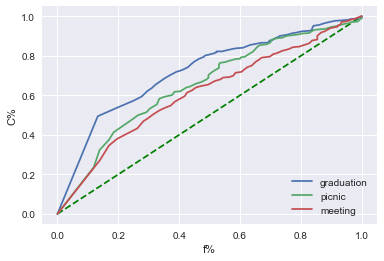

In [22]:
import numpy as np
import matplotlib.pyplot as plt
CATEGORIES = ["graduation", "picnic","meeting"] 
x = np.linspace(0, 1, 1000)

fig, ax = plt.subplots()
ax.plot(x, x, '--g')

for j in range(len(CATEGORIES)):
    plt.plot(FPR[j], TPR[j],label= CATEGORIES[j])
    plt.legend(loc='lower right',fontsize=10)
plt.xlabel('f%')
plt.ylabel('C%')

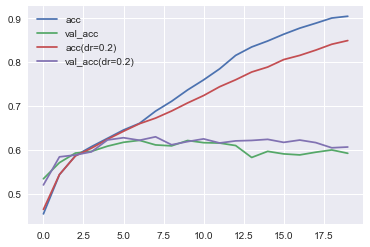

In [17]:
# import tensorboard data
tb0 = pd.read_csv('run_fpz-3cnn-dr-1537389732-tag-acc.csv',sep=',')
tba0 = pd.read_csv('run_fpz-3cnn-dr-1537389732-tag-val_acc.csv',sep=',')
tb1 = pd.read_csv('run_fpz-3cnn-2dr-1537409526-tag-acc.csv',sep=',')
tba1 = pd.read_csv('run_fpz-3cnn-2dr-1537409526-tag-val_acc.csv',sep=',')

#run_fpz-3cnn-2dr-1537409526-tag-acc
tb = tb0.drop('Wall time',axis=1)
tba = tba0.drop('Wall time',axis=1)

plt.plot(tb['Value'],label = 'acc')
plt.plot(tba['Value'],label = 'val_acc')
plt.plot(tb1['Value'],label = 'acc(dr=0.2)')
plt.plot(tba1['Value'],label = 'val_acc(dr=0.2)')

plt.legend()

# Fit the curves:

In [18]:
import numpy as np
from pylab import *
from scipy.optimize import curve_fit

#https://micropore.wordpress.com/2017/02/04/python-fit-with-error-on-y-axis/


k = 0  #noise size
nstd = 1. # to draw x-sigma intervals


def func(x, b ):

    return(np.tanh(b*x))

# data 
x_0 = np.array(FPR[0])
x_1 = np.array(FPR[1])
x_2 = np.array(FPR[2])

y_0 = np.array(TPR[0])
y_1 = np.array(TPR[1])
y_2 = np.array(TPR[2])



# curve fit [with only y-error]
popt_0, pcov_0 = curve_fit(func, x_0, y_0) # ,sigma=1./(noise_0*noise_0)
perr_0 = np.sqrt(np.diag(pcov_0))
popt_1, pcov_1 = curve_fit(func, x_1, y_1) # ,sigma=1./(noise_1*noise_1)
perr_1 = np.sqrt(np.diag(pcov_1))
popt_2, pcov_2 = curve_fit(func, x_2, y_2) # ,sigma=1./(noise_2*noise_2)
perr_2 = np.sqrt(np.diag(pcov_2))



# prepare confidence level curves

popt_up_0 = popt_0 + nstd * perr_0
popt_dw_0 = popt_0 - nstd * perr_0

popt_up_1 = popt_1 + nstd * perr_1
popt_dw_1 = popt_1 - nstd * perr_1

popt_up_2 = popt_2 + nstd * perr_2
popt_dw_2 = popt_2 - nstd * perr_2

fit_0 = func(x_0, popt_0)
fit_1 = func(x_1, popt_1)
fit_2 = func(x_2, popt_2)


fit parameter 1.0-sigma error
———————————–
2.1198740140900387 +- 0.049142763668801395


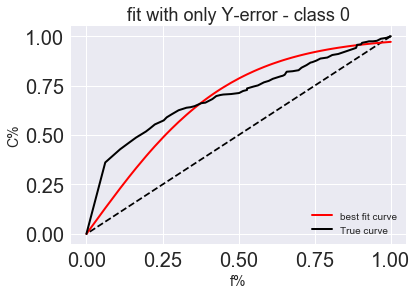

In [22]:
#print fit parameters and 1-sigma estimates
print('fit parameter ' + str(nstd)+ '-sigma error')
print('———————————–')
for i in range(len(popt_0)):
    print(str(popt_0[i]) + ' +- ' + str(perr_0[i]) )

#plot
fig, ax = plt.subplots(1)
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['font.size']= 20
#errorbar(x_0, y0_0, yerr=noise_0, xerr=0, hold=True, ecolor='k', fmt='none', label='data')

xlabel('f%', fontsize=14)
ylabel('C%', fontsize=14)
title('fit with only Y-error - class 0', fontsize=18)
plot(x_0,x_0,'--k')
plot(x_0, fit_0, 'r', lw=2, label='best fit curve')
plot(x_0, y_0, 'k-', lw=2, label='True curve')
#ax.fill_between(x_0, fit_up_0, fit_dw_0, alpha=0.4, label= str(nstd)+ '-sigma interval')
legend(loc='lower right',fontsize=10)

fit parameter 1.0-sigma error
———————————–
2.130942761161619 +- 0.022891260900638085


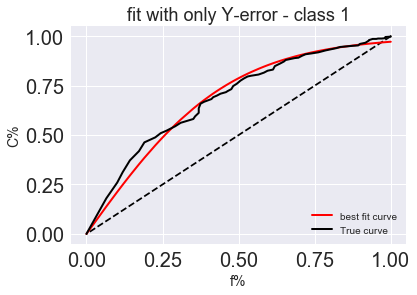

In [23]:
#print fit parameters and 1-sigma estimates
print('fit parameter ' + str(nstd)+ '-sigma error')
print('———————————–')
for i in range(len(popt_1)):
    print(str(popt_1[i]) + ' +- ' + str(perr_1[i]) )

#plot
fig, ax = plt.subplots(1)
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['font.size']= 20
#errorbar(x_1, y0_1, yerr=noise_1, xerr=0, hold=True, ecolor='k', fmt='none', label='data')

xlabel('f%', fontsize=14)
ylabel('C%', fontsize=14)
title('fit with only Y-error - class 1', fontsize=18)
plot(x_1,x_1,'--k')
plot(x_1, fit_1, 'r', lw=2, label='best fit curve')
plot(x_1, y_1, 'k-', lw=2, label='True curve')
#ax.fill_between(x_1, fit_up_1, fit_dw_1, alpha=.4, label= str(nstd)+ '-sigma interval')
legend(loc='lower right',fontsize=10)

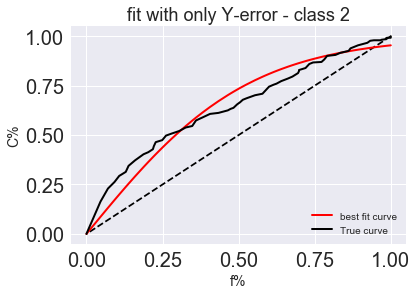

In [24]:

#plot
fig, ax = plt.subplots(1)
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['font.size']= 20
#errorbar(x_2, y0_2, yerr=noise_2, xerr=0, hold=True, ecolor='k', fmt='none', label='data')

xlabel('f%', fontsize=14)
ylabel('C%', fontsize=14)
title('fit with only Y-error - class 2', fontsize=18)
plot(x_2,x_2,'--k')
plot(x_2, fit_2, 'r', lw=2, label='best fit curve')
plot(x_2, y_2, 'k-', lw=2, label='True curve')
#ax.fill_between(x_2, fit_up_2, fit_dw_2, alpha=.25, label= str(nstd)+ '-sigma interval')
legend(loc='lower right',fontsize=10)

# AUC PARAMETERS

In [26]:
from scipy import integrate
f0=func(x_0,popt_0)
AUC_0 = integrate.quad(func, 0, 1,args=popt_0)
AUC_1 = integrate.quad(func, 0, 1,args=popt_1)
AUC_2 = integrate.quad(func, 0, 1,args=popt_2)
print('AUC parameter class 0:',str(AUC_0[0]) + '+-' + str(AUC_0[1]) )
print('AUC parameter class 1:',str(AUC_1[0]) + '+-' + str(AUC_1[1]) )
print('AUC parameter class 2:',str(AUC_2[0]) + '+-' + str(AUC_2[1]) )

AUC parameter class 0: 0.6797739827404218+-1.0051387222257235e-13
AUC parameter class 1: 0.6812913448748024+-1.1096666719304618e-13
AUC parameter class 2: 0.6428085056346791+-7.136608033805104e-15
